### 目录
 
 - 准备模型开发环境
 - 生成验证码数据集
 - 输入与输出数据处理
 - 模型结构设计
 - 模型损失函数设计
 - 模型训练过程分析
 - 模型部署与效果演示

### 四、模型结构设计

**1.图像分类模型AlexNet**

**2.图像分类模型VGG-16**

**3.验证码识别模型结构**

**4.验证码识别模型实现**

**a.引入第三方包**

In [59]:
from PIL import Image
from keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.models import *
from keras.layers import *

import glob
import pickle

import numpy as np

import matplotlib.pyplot as plt

**b.变量以及函数定义**

**定义超参数和字符集**

In [60]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
LOWERCASE = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z']
UPPERCASE = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
           'V', 'W', 'X', 'Y', 'Z']

CAPTCHA_CHARSET = NUMBER   # 验证码字符集
CAPTCHA_LEN = 4            # 验证码长度
CAPTCHA_HEIGHT = 60        # 验证码高度
CAPTCHA_WIDTH = 160        # 验证码宽度

TRAIN_DATA_DIR = '.\\train-data\\' # 验证码数据集目录
TEST_DATA_DIR = '.\\test-data\\'

BATCH_SIZE = 128
EPOCHS = 100
OPT = 'adam'
LOSS = 'binary_crossentropy'

MODEL_DIR = './model/train_demo/'
MODEL_FORMAT = '.h5'
HISTORY_DIR = './history/train_demo/'
HISTORY_FORMAT = '.history'

filename_str = "{}captcha_{}_{}_bs_{}_epochs_{}{}"

# 模型网络结构文件
MODEL_VIS_FILE = 'captcha_classfication' + '.png'
# 模型文件
MODEL_FILE = filename_str.format(MODEL_DIR, OPT, LOSS, str(BATCH_SIZE), str(EPOCHS), MODEL_FORMAT)
# 训练记录文件
HISTORY_FILE = filename_str.format(HISTORY_DIR, OPT, LOSS, str(BATCH_SIZE), str(EPOCHS), HISTORY_FORMAT)

**将RGB验证码图像转为灰度图**

In [61]:
def rgb2gray(img):
    # Y' = 0.299 R + 0.587 G + 0.114 B 
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

**对验证码中每个字符进行one-hot编码**

In [62]:
# 定义one-hot编码函数
# CAPTCHA_CHARSET = NUMBER   # 验证码字符集
# CAPTCHA_LEN = 4            # 验证码长度
def text2vec(text,length=CAPTCHA_LEN,charset=CAPTCHA_CHARSET):
    text_len = len(text)
    # 验证码长度校验
    if text_len != length:
        raise ValueError("Error:length of captcha should be{},but got {}".format(length,text_len))
    # 生成一个形如(CAPTCHA_LEN*CAPTCHA_CHARSET)的一维向量
    # 例如，4个纯数字的验证码生成形如(4*10,)的一维向量
    vec = np.zeros(length*len(charset))
    for i in range(length):
        # One-hot编码验证码中的每个数字
        # 每个字符的热码 = 索引 +偏移量
        vec[charset.index(text[i]) + i*len(charset)] = 1
    return vec

**将验证码向量解码为对应字符**

这段代码是一个将向量转换成文本的函数。它输入一个向量 vector，并将其转换成一个文本字符串。如果 vector 不是一个 ndarray 数组，则将其转换成一个 ndarray 数组。然后，将 vector 重塑为一个形状为 [CAPTCHA_LEN, -1] 的数组。其中 CAPTCHA_LEN 是一个常量，表示验证码的长度。在这个函数中，将 vector 拆分成长度为 CAPTCHA_LEN 的一维数组，然后使用 np.argmax() 函数找到每个数组中概率最大的索引，并使用 CAPTCHA_CHARSET 中对应的字符将其添加到文本字符串中。最后，返回文本字符串作为输出。

In [63]:
def vec2text(vector):
    if not isinstance(vector, np.ndarray):
        vector = np.asarray(vector)
    vector = np.reshape(vector, [CAPTCHA_LEN, -1])
    text = ''
    for item in vector:
        text += CAPTCHA_CHARSET[np.argmax(item)]
    return text

**适配Keras图像数据格式**


这段代码是一个用于将图像数据转换为适合于 Keras 模型的格式的函数。它输入一个图像 batch，以及图像的高度和宽度（rows 和 cols）。首先，检查图像数据的格式是否为 'channels_first'。如果是，则将 batch 重塑为形状为 (batch.shape[0], 1, rows, cols) 的四维数组，并将 input_shape 设置为 (1, rows, cols)。这个四维数组的第一个维度是 batch_size，第二个维度是通道数（在这里是 1），第三个和第四个维度是图像的高度和宽度。如果图像数据的格式不是 'channels_first'，则将 batch 重塑为形状为 (batch.shape[0], rows, cols, 1) 的四维数组，并将 input_shape 设置为 (rows, cols, 1)。这个四维数组的第一个维度是 batch_size，第二个和第三个维度是图像的高度和宽度，第四个维度是通道数（在这里是 1）。最后，将处理后的 batch 和 input_shape 作为输出返回。

In [64]:
def fit_keras_channels(batch, rows=CAPTCHA_HEIGHT, cols=CAPTCHA_WIDTH):
    if K.image_data_format() == 'channels_first':
        batch = batch.reshape(batch.shape[0], 1, rows, cols)
        input_shape = (1, rows, cols)
    else:
        batch = batch.reshape(batch.shape[0], rows, cols, 1)
        input_shape = (rows, cols, 1)
    
    return batch, input_shape

**c.读取训练集**

In [65]:
X_train = []
Y_train = []
for filename in glob.glob(TRAIN_DATA_DIR + "*.png"):
    X_train.append(np.array(Image.open(filename)))
    Y_train.append(filename.lstrip(TRAIN_DATA_DIR).rstrip(".png"))

**d.处理训练集图像**



这段代码用于将图像数据进行预处理，使其适合于 Keras 模型的输入。首先，将输入的图像数据转换成 numpy 格式，并将数据类型设置为 np.float32。接下来，使用 rgb2gray() 函数将 RGB 彩色图像转换为灰度图像。然后，将图像数据进行归一化，将像素值从 [0, 255] 的范围缩放到 [0, 1] 的范围。最后，使用 fit_keras_channels() 函数将图像数据转换成适合于 Keras 模型的格式，并将处理后的结果作为输出打印出来。其中，X_train 是包含训练图像数据的列表，input_shape 是 Keras 模型的输入形状。

In [66]:
# list -> rgb(numpy)
X_train = np.array(X_train, dtype=np.float32)
# rgb -> gray
X_train = rgb2gray(X_train)
# normalize
X_train = X_train / 255
# Fit keras channels
X_train, input_shape = fit_keras_channels(X_train)

print(X_train.shape, type(X_train))
print(input_shape)

(8266, 60, 160, 1) <class 'numpy.ndarray'>
(60, 160, 1)


**e.处理训练集标签(one-hot编码)**

In [67]:
Y_train = list(Y_train)

for i in range(len(Y_train)):
    Y_train[i] = text2vec(Y_train[i])

Y_train = np.asarray(Y_train)

print(Y_train.shape, type(Y_train))
print(Y_train[0])

(8266, 40) <class 'numpy.ndarray'>
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


**f.读取测试集，处理对应图像和标签**

这段代码是一个测试数据集的预处理过程。它首先使用glob库来读取一个文件夹中所有以.png结尾的文件，然后将每个文件读取为numpy数组，并将它们添加到X_test列表中。同时，文件名也被添加到Y_test列表中，并且经过一些处理（lstrip和rstrip），只保留了文件名中间的文本部分。接下来，X_test数组被转换为灰度图像，并进行了归一化处理。最后，Y_test列表中的每个文本标签也被转换为向量形式，并转换为numpy数组。最后打印出X_test和Y_test的形状和类型。

In [68]:
X_test = []
Y_test = []

for filename in glob.glob(TEST_DATA_DIR + "*.png"):
    X_test.append(np.array(Image.open(filename)))
    Y_test.append(filename.lstrip(TEST_DATA_DIR).rstrip("*.png"))

# list->numpy(rgb)->gray->normalization->fit keras
X_test = np.array(X_test,dtype=np.float32)
X_test = rgb2gray(X_test)
X_test = X_test / 255
X_test,_ = fit_keras_channels(X_test)

Y_test = list(Y_test)
for i in range(len(Y_test)):
    Y_test[i] = text2vec(Y_test[i])

Y_test = np.asarray(Y_test)

print(X_test.shape,type(X_test))
print(Y_test.shape,type(Y_test))

(2607, 60, 160, 1) <class 'numpy.ndarray'>
(2607, 40) <class 'numpy.ndarray'>


**g.创建验证码识别模型**

这段代码是一个卷积神经网络（CNN）的模型定义和编译过程。首先，定义了一个输入层，接着定义了三层卷积层和池化层，并在第三层卷积层后将特征图flatten（摊平）成一维向量。然后，在全连接网络中加入了一个dropout层，以减轻过拟合的问题。接下来，定义了4个全连接层分别做10分类，分别对应4个字符，使用softmax作为激活函数。最后，将4个字符向量拼接在一起，与标签向量形式一致，作为模型输出。最后，使用compile函数编译模型，使用给定的优化器、损失函数和评估指标。

In [69]:
# 输入层
inputs = Input(shape = input_shape,name = "inputs")

# 第1层卷积
conv1 = Conv2D(32,(3,3),name="conv1")(inputs)
relu1 = Activation("relu",name="relu1")(conv1)

# 第2层卷积
conv2 = Conv2D(32,(3,3),name ="conv2")(relu1)
relu2 = Activation("relu",name="relu2")(conv2)
pool2 = MaxPooling2D(pool_size=(2,2),padding="same",name="pool2")(relu2)

# 第3层卷积
conv3 = Conv2D(64,(3,3),name="conv3")(pool2)
relu3 = Activation("relu",name="relu3")(conv3)
pool3 = MaxPooling2D(pool_size=(2,2),padding="same",name="pool3")(relu3)

# 将Pooled feature map 摊平后输入全连接网络
x = Flatten()(pool3)

# Dropout
x = Dropout(0.25)(x)

# 4个全连接层分别做10分类，分别对应4个字符 
x = [Dense(10,activation="softmax",name="fc%d"%(i+1))(x) for i in range(4)]

# 4个字符向量拼接在一起，与标签向量形式一致，作为模型输出
outs = Concatenate()(x)

# 定义模型的输入与输出
model = Model(inputs=inputs,outputs=outs)
model.compile(optimizer=OPT,loss=LOSS,metrics=["acc"])

In [70]:
# 查看模型摘要
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 60, 160, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 58, 158, 32)  320         ['inputs[0][0]']                 
                                                                                                  
 relu1 (Activation)             (None, 58, 158, 32)  0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv2D)                 (None, 56, 156, 32)  9248        ['relu1[0][0]']            

**h.训练模型**

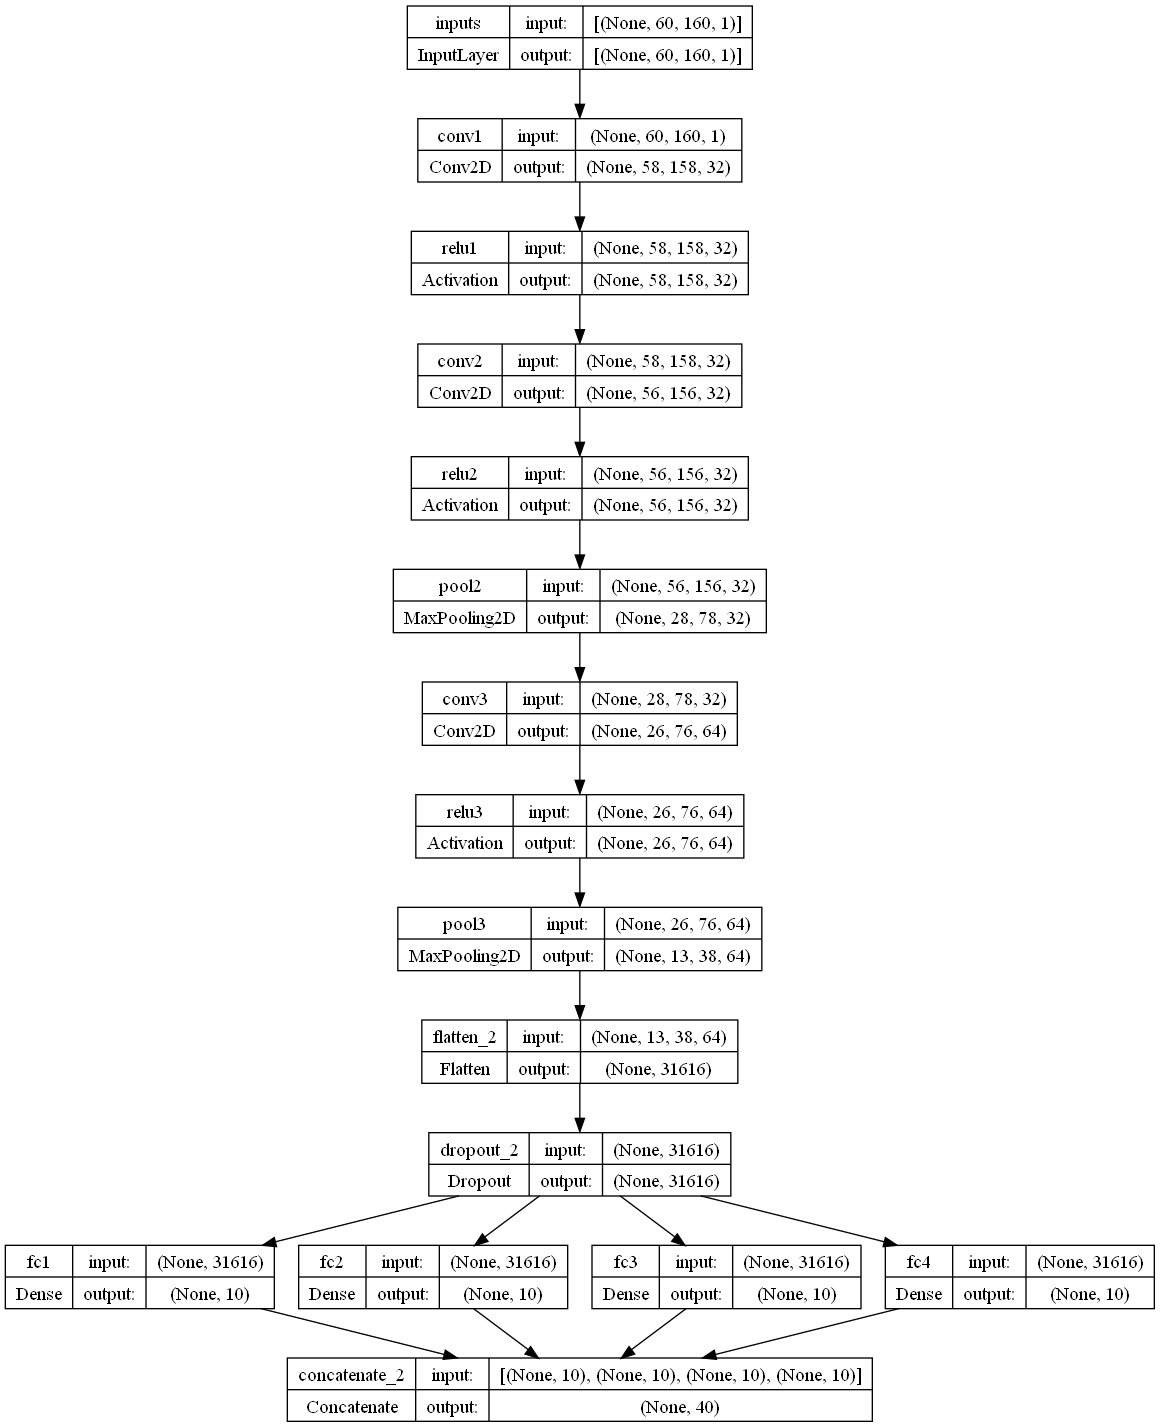

In [71]:
# 模型可视化
plot_model(model,to_file=MODEL_VIS_FILE,show_shapes=True)

In [72]:
# 训练模型
history = model.fit(X_train,
                   Y_train,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=2,
                   validation_data=(X_test,Y_test))

Epoch 1/100
65/65 - 114s - loss: 0.3261 - acc: 0.0648 - val_loss: 0.3236 - val_acc: 7.6717e-04 - 114s/epoch - 2s/step
Epoch 2/100
65/65 - 90s - loss: 0.3059 - acc: 0.1740 - val_loss: 0.2721 - val_acc: 0.2862 - 90s/epoch - 1s/step
Epoch 3/100
65/65 - 95s - loss: 0.2306 - acc: 0.3314 - val_loss: 0.2097 - val_acc: 0.3832 - 95s/epoch - 1s/step
Epoch 4/100
65/65 - 90s - loss: 0.1789 - acc: 0.3933 - val_loss: 0.1763 - val_acc: 0.3962 - 90s/epoch - 1s/step
Epoch 5/100
65/65 - 98s - loss: 0.1501 - acc: 0.4148 - val_loss: 0.1583 - val_acc: 0.4331 - 98s/epoch - 2s/step
Epoch 6/100
65/65 - 97s - loss: 0.1320 - acc: 0.4423 - val_loss: 0.1464 - val_acc: 0.4538 - 97s/epoch - 1s/step
Epoch 7/100
65/65 - 97s - loss: 0.1198 - acc: 0.4636 - val_loss: 0.1409 - val_acc: 0.4538 - 97s/epoch - 1s/step
Epoch 8/100
65/65 - 98s - loss: 0.1121 - acc: 0.4730 - val_loss: 0.1380 - val_acc: 0.4707 - 98s/epoch - 2s/step
Epoch 9/100
65/65 - 95s - loss: 0.1051 - acc: 0.4792 - val_loss: 0.1332 - val_acc: 0.4918 - 95s/ep

KeyboardInterrupt: 

**i.预测样例**

In [79]:
# 真实值
print(vec2text(Y_test[6]))

0020


In [80]:
# 预测值
yy = model.predict(X_test[6].reshape(1,60,160,1))
print(vec2text(yy))

1/1 [==============================] - 0s 70ms/step
0020


**j.保存模型**

In [ ]:

model.save(MODEL_FILE)
print("saved trained model at %s" %MODEL_FILE)

saved trained model at ./model/train_demo/captcha_adam_binary_crossentropy_bs_100_epochs_50.h5


**k.保存训练过程记录**

In [ ]:
history.history["acc"]

[0.030970240011811256,
 0.24679408967494965,
 0.40091943740844727,
 0.43769657611846924,
 0.4571739733219147,
 0.4721751809120178,
 0.4808855652809143,
 0.5004839301109314,
 0.5002419352531433,
 0.512218713760376,
 0.5148802399635315,
 0.5206871628761292,
 0.5243164896965027,
 0.5225018262863159,
 0.5372610688209534,
 0.5361722707748413,
 0.5423421263694763,
 0.5407693982124329,
 0.5457295179367065,
 0.5453665852546692,
 0.5506895780563354,
 0.5508105754852295,
 0.5435519218444824,
 0.5517783761024475,
 0.5494797825813293,
 0.5527461767196655,
 0.5558916330337524,
 0.5549237728118896,
 0.5568594336509705,
 0.5629082918167114,
 0.561456561088562,
 0.5593999624252319,
 0.5577062368392944,
 0.5637551546096802,
 0.5608516931533813,
 0.561456561088562,
 0.5637551546096802,
 0.5648439526557922,
 0.5701669454574585,
 0.5619404911994934,
 0.5641180872917175,
 0.5724655389785767,
 0.5682312846183777,
 0.5684732794761658,
 0.5700459480285645,
 0.5654488205909729,
 0.5661746859550476,
 0.57403820

In [ ]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:


with open(HISTORY_FILE,"wb") as f:
    pickle.dump(history.history,f)

In [ ]:
print(HISTORY_FILE)

./history/train_demo/captcha_adam_binary_crossentropy_bs_100_epochs_50.history


### 五、模型损失函数设计

**1.交叉熵（Cross-Entropy，CE）**

**2.Categorical CE Loss(Softmax Loss)**

**3.Binary CE Loss(Sigmoid CE LOSS)**

**4.不同损失函数对比**

**a.引入第三方包**

In [ ]:
import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt

**b.定义过程可视化方法**

这段代码是一个用于绘制模型训练历史数据的函数。它接受一个历史数据字典，用于绘制每个模型在训练过程中的准确率或损失率的变化。metric参数指定绘制的指标，可以是"acc"（准确率）或"loss"（损失率），title参数指定图表标题，loc参数指定图例的位置。在函数中，首先创建一个画布，然后遍历历史数据字典中的每个模型，将其准确率或损失率绘制到图表中。最后展示图表。

In [ ]:
def plot_training(history=None, metric='acc', title='Model Accuracy', loc='lower right'):
    model_list = []
    fig = plt.figure(figsize=(10, 8))
    for key, val in history.items():
        model_list.append(key.replace(HISTORY_DIR, '').rstrip('.history'))
        plt.plot(val[metric])

    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(model_list, loc=loc)
    plt.show()

**c.加载预训练模型**

In [ ]:
HISTORY_DIR = './pre-trained/history/loss/'
history = {}
for filename in glob.glob(HISTORY_DIR + '*.history'):
    with open(filename, 'rb') as f:
        history[filename] = pickle.load(f)

In [ ]:
for key, val in history.items():
    print(key.replace(HISTORY_DIR, '').rstrip('.history'), val.keys())

./pre-trained/history/loss\captcha_rmsprop_binary_crossentropy_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
./pre-trained/history/loss\captcha_rmsprop_categorical_crossentropy_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
./pre-trained/history/loss\captcha_rmsprop_mse_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
./pre-trained/history/loss\captcha_rmsprop_poisson_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


**d.准确率变化（训练集）**

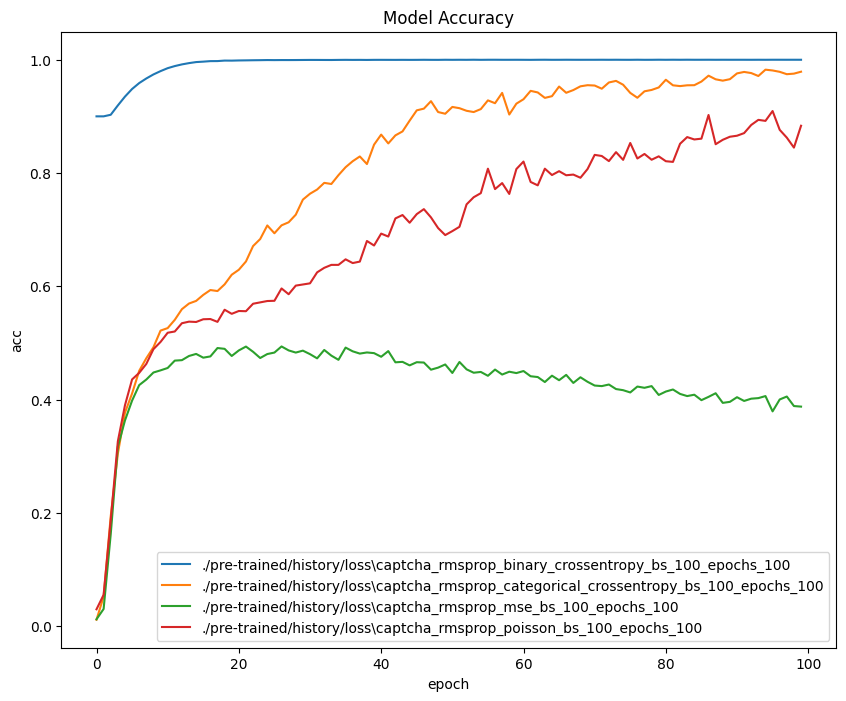

In [ ]:
# del history[HISTORY_DIR+'captcha_rmsprop_categorical_crossentropy_bs_100_epochs_100'+'.history']
plot_training(history)

**e.损失值变化(训练集)**

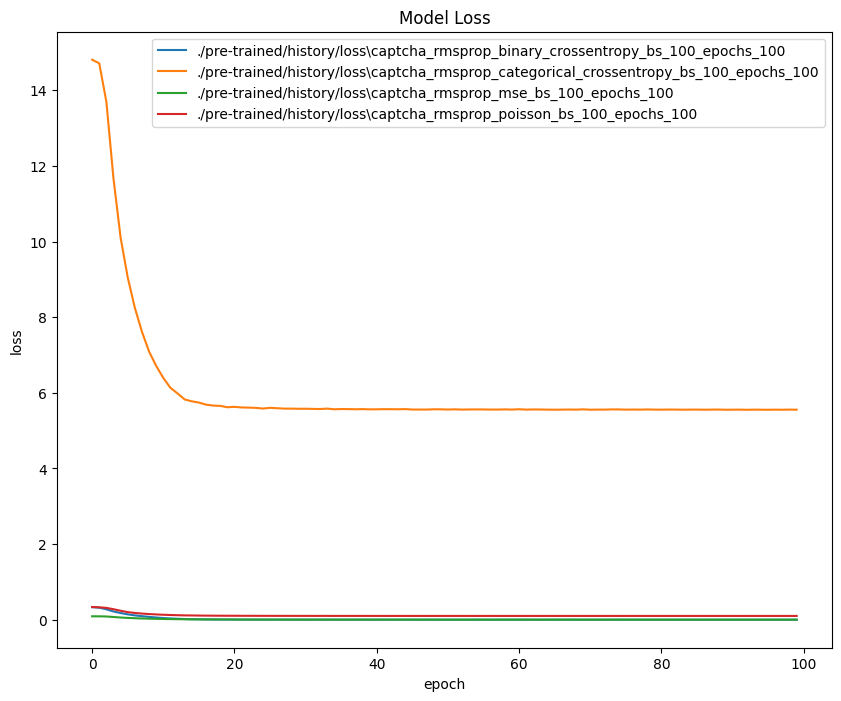

In [ ]:
plot_training(history, metric='loss', title='Model Loss', loc='upper right')

**f.准确率变化（测试集）**

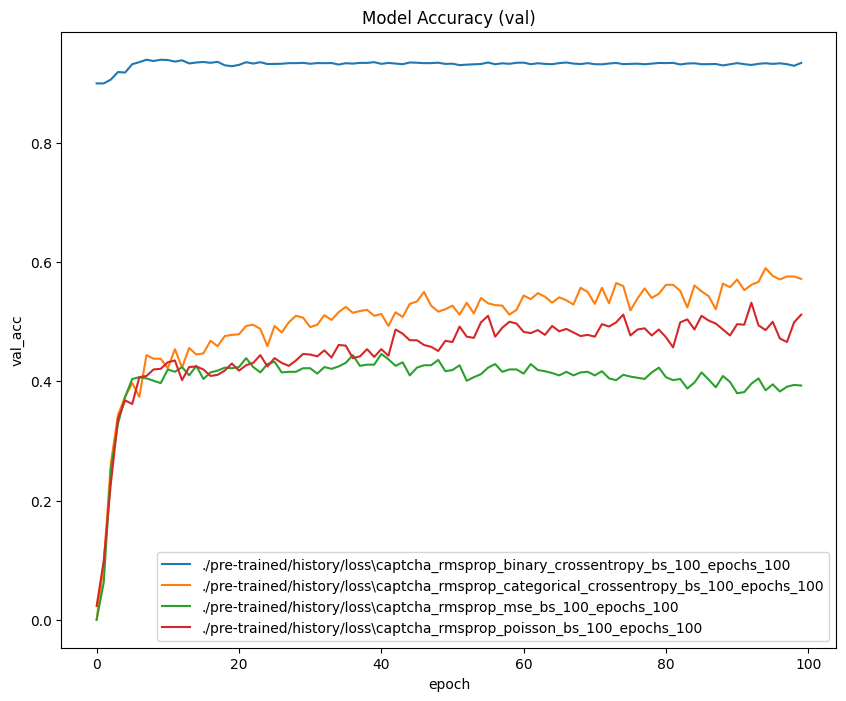

In [ ]:
plot_training(history, metric='val_acc', title='Model Accuracy (val)')

**g.损失值变化(测试集)**

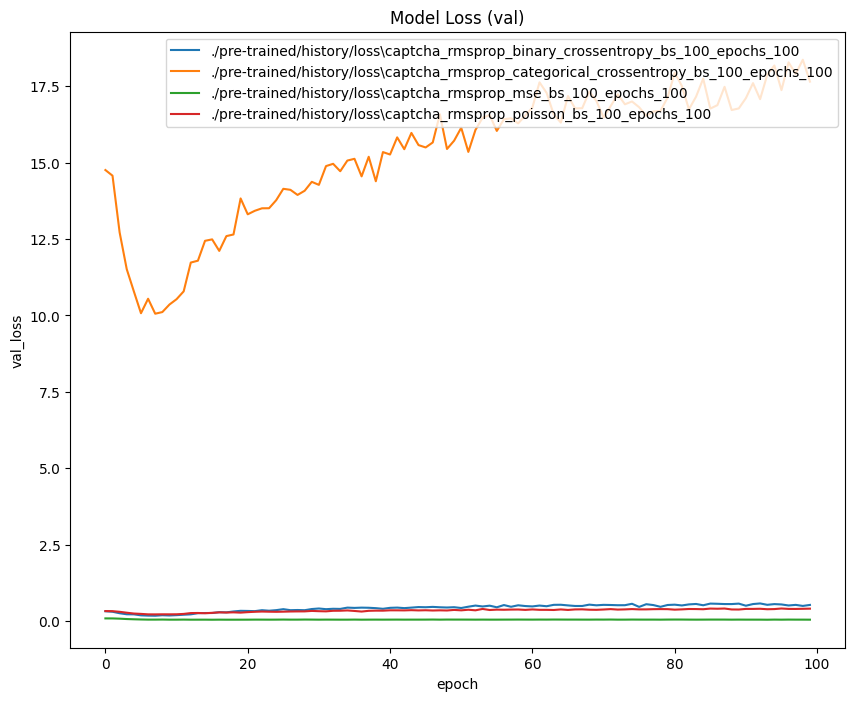

In [ ]:
plot_training(history, metric='val_loss', title='Model Loss (val)', loc='upper right')

### 六、模型训练过程分析

**1.优化器介绍:SGD(Stochastic Gradient Descent)**

**2.优化器介绍：SGD-M（Momentum）**

**3.优化器介绍：Adagrad-RMSprop-Adam**

**4.优化器对比**

**a.引入第三方包**

In [ ]:
import glob
import pickle

import numpy as np
import matplotlib.pyplot as plt

**b.加载训练过程记录**

In [ ]:
history_file = './pre-trained/history/binary_ce/captcha_adam_binary_crossentropy_bs_100_epochs_100.history'
with open(history_file,"rb") as f:
    history = pickle.load(f)

**c.训练过程可视化**

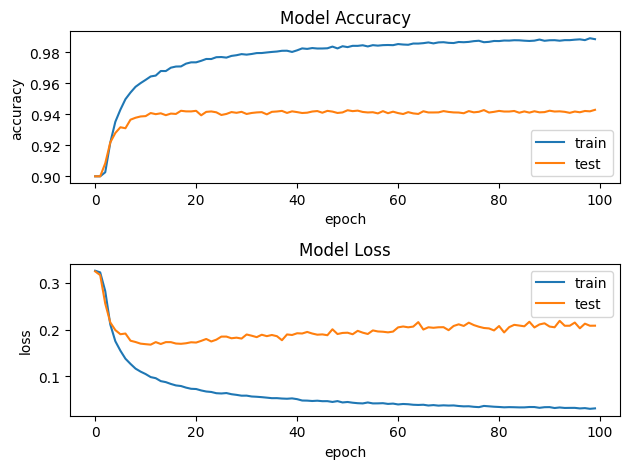

In [ ]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

plt.show()

**d.定义过程可视化方法**

In [ ]:
def plot_training(history=None, metric='acc', title='Model Accuracy', loc='lower right'):
    model_list = []
    fig = plt.figure(figsize=(10, 8))
    for key, val in history.items():
        model_list.append(key.replace(HISTORY_DIR, '').rstrip('.history'))
        plt.plot(val[metric])

    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(model_list, loc=loc)
    plt.show()

**e.加载预训练模型记录**

In [ ]:
HISTORY_DIR = '.\\pre-trained\\history\\binary_ce\\'
history = {}
for filename in glob.glob(HISTORY_DIR + '*.history'):
    with open(filename, 'rb') as f:
        history[filename] = pickle.load(f)

In [ ]:
for key, val in history.items():
    print(key.replace(HISTORY_DIR, '').rstrip('.history'), val.keys())

captcha_adadelta_binary_crossentropy_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
captcha_adagrad_binary_crossentropy_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
captcha_adam_binary_crossentropy_bs_100_epochs_100 dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
captcha_rmsprop_binary_crossentropy_bs_100_epochs_100 (1) dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


**f.准确率变化(训练集)**

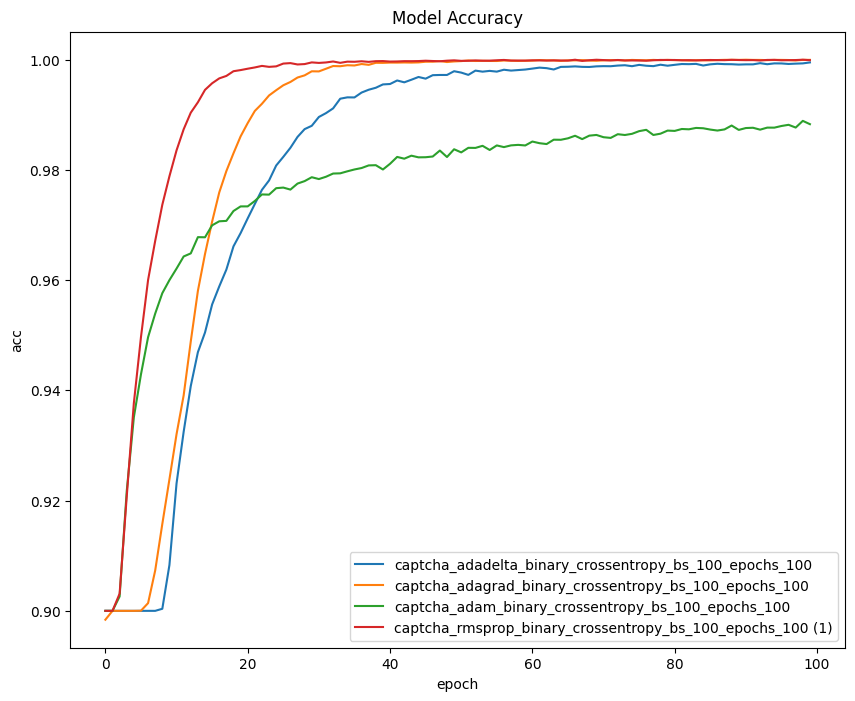

In [ ]:
plot_training(history)

**g.损失值变化（训练集）**

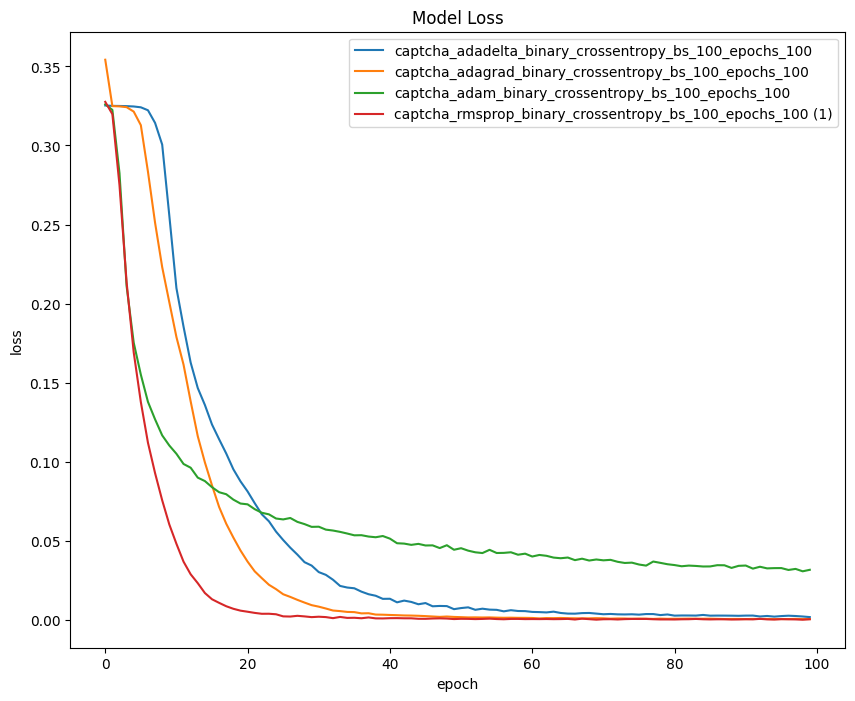

In [ ]:
plot_training(history, metric='loss', title='Model Loss', loc='upper right')

**h.准确率变化（测试集）**

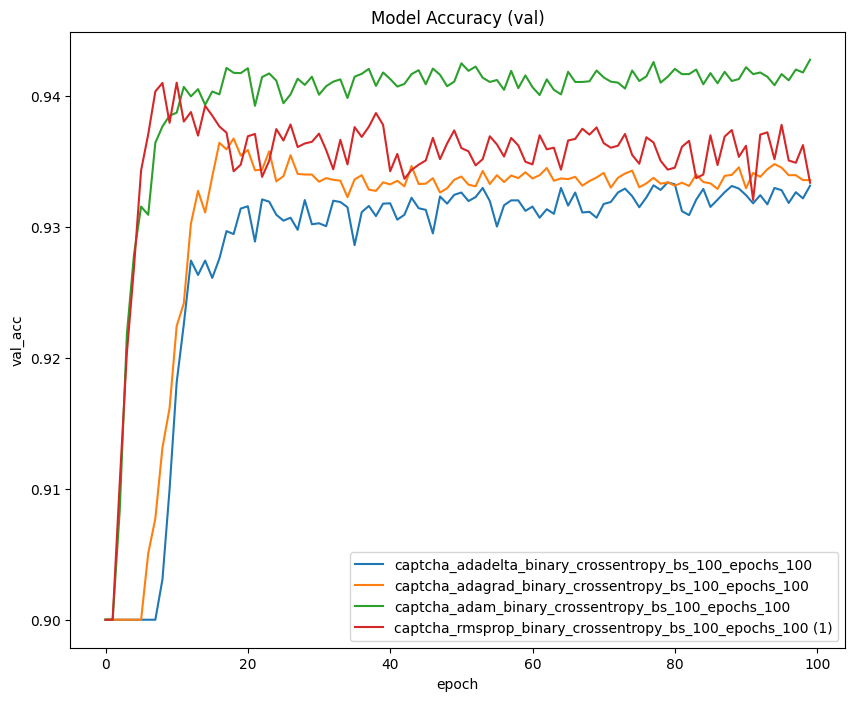

In [ ]:
plot_training(history, metric='val_acc', title='Model Accuracy (val)')

**i.损失值变化（测试集）**

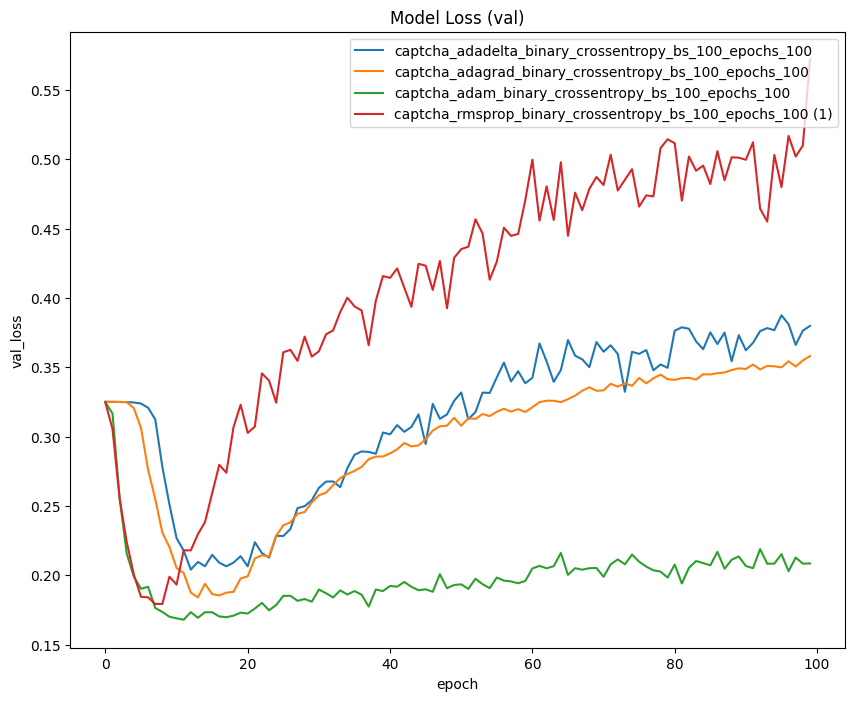

In [ ]:
plot_training(history, metric='val_loss', title='Model Loss (val)', loc='upper right')